# NLP 기초 Assignment
## NLP 맛보기 - spam.csv를 가지고 유의미한 해석을 도출해주세요!

In [1]:
# 필요한 모듈 불러오기
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from gensim.models import Word2Vec, FastText

## Load Data
- 보시면 아시다시피 spam.csv는 라벨이 있는 데이터입니다. 물론 7주차 주제가 텍스트 기초인만큼 텍스트만 활용하셔도 되고, 라벨까지 활용하셔서 모델을 돌려보셔도 좋습니다 :)

In [2]:
import os

path = '/home/mskang/hyeokjong/assignment/NLP/assi/spam.csv'  # Path to corpus
spam = pd.read_csv(path)

In [3]:
spam.shape

(5572, 2)

In [4]:
# label
spam.v1

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: v1, Length: 5572, dtype: object

In [5]:
# text
spam.v2

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object

In [6]:
# example
spam.iloc[5]

v1                                                 spam
v2    FreeMsg Hey there darling it's been 3 week's n...
Name: 5, dtype: object

In [7]:
# labeling  
spam.v1 = (spam.v1 == 'spam')*1
spam

# spam = 1
# ham = 0

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [8]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [9]:
spam.v2.nunique()

# 중복 있음

5169

In [10]:
# 중복 제거
spam.drop_duplicates(subset = ['v2'], inplace = True)
spam.v2.nunique()

5169

In [11]:
print(f"There are {(spam.v1 == 1).sum()} spam and {(spam.v1 == 0).sum()} ham")
print(f"spam : {(spam.v1 == 1).sum() / ( (spam.v1 == 1).sum() + (spam.v1 == 0).sum() )}%")

There are 653 spam and 4516 ham
spam : 0.12633004449603405%


In [12]:
# 정규표현식 이용하여 문자가 아닌 것은 제거 and 소문자로

import re

def re_text(corpus):
    new = re.sub('[^a-zA-Z]', ' ', corpus).lower() 
    return new

spam.v2 = spam.v2.apply(re_text)

In [13]:
spam.v2

0       go until jurong point  crazy   available only ...
1                           ok lar    joking wif u oni   
2       free entry in   a wkly comp to win fa cup fina...
3       u dun say so early hor    u c already then say   
4       nah i don t think he goes to usf  he lives aro...
                              ...                        
5567    this is the  nd time we have tried   contact u...
5568                will    b going to esplanade fr home 
5569    pity    was in mood for that  so   any other s...
5570    the guy did some bitching but i acted like i d...
5571                           rofl  its true to its name
Name: v2, Length: 5169, dtype: object

## Tokenizing


In [14]:
nltk.download('punkt')
nltk.download('stopwords') 
stops = list(stopwords.words('english'))


[nltk_data] Downloading package punkt to /home/mskang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mskang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
stops[:10]

# 이건 document에서 딱히 의미가 없음. 즉, train에 필요 없어서 이걸 제거해야합니다. 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [16]:
tokens = []
for text in spam.v2 :             # 모든 문장마다
    words = word_tokenize(text)   # 토큰화
    words = [word for word in words if word not in stops]  # english_stops은 포함 안되게
    tokens.append(words)
spam.v2 = tokens    # change to tokenized sentence

In [17]:
spam[:5]

# 정규 표현식을 이용한 필요없는 문자제거
# 모두 소문자화
# 토큰화
# stop word 제거

,v1,v2
0,0,"[go, jurong, point, crazy, available, bugis, n..."
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, think, goes, usf, lives, around, though]"


## Embedding

- 수업에서 다룬 임베딩 방법에는 One-hot encoding, CBOW, Skip-gram, GloVe, FastText, EMlo가 있었습니다. 다양한 시도와 '비교' 결과를 함께 적어주세요! 파라미터를 조정해가는 과정도 해석에 도움이 될 수 있겠죠 :)

In [18]:
# spam / ham별로 count tokens 
cnt_spam = CountVectorizer(max_features= 300, stop_words = 'english', lowercase= False)
cnt_ham = CountVectorizer(max_features= 300, stop_words = 'english', lowercase= False)

corpus_spam = sum(spam[spam.v1 == 1]['v2'], [])
corpus_ham = sum(spam[spam.v1 == 0]['v2'], [])

cnt_spam_t = cnt_spam.fit_transform(corpus_spam)
cnt_ham_t = cnt_ham.fit_transform(corpus_ham)


In [19]:
word_count_spam = pd.DataFrame( {'words' : cnt_spam.get_feature_names(),'counts' : cnt_spam_t.sum(axis = 0).flat} )
word_count_ham = pd.DataFrame( {'words' : cnt_ham.get_feature_names(),'counts' : cnt_ham_t.sum(axis = 0).flat} )

/home/mskang/.conda/envs/hyeokjong2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
# spam에서 빈도수 높은 token
word_count_spam.sort_values('counts', ascending = False).head(10)

,words,counts
87,free,197
258,txt,141
265,ur,119
233,stop,114
150,mobile,111
242,text,109
207,reply,96
40,claim,96
292,www,83
198,prize,82


In [21]:
# ham에서 빈도수 높은 token
word_count_ham.sort_values('counts', ascending = False).head(10)

,words,counts
90,gt,288
142,lt,287
178,ok,255
88,got,239
122,know,225
133,like,222
87,good,215
40,come,212
265,ur,198
251,time,192


In [22]:
# spam 에서 빈도수 낮은 token -> 아래 min_count에서 사용하기 위해  
word_count_spam.sort_values('counts', ascending = True).head(10)

,words,counts
299,zed,6
256,tscs,6
237,summer,6
235,subscription,6
50,congrats,6
55,cr,6
71,discount,6
179,pc,6
97,got,6
101,guess,6


In [23]:
# spam 에서 빈도수 낮은 token -> 아래 min_count에서 사용하기 위해  
word_count_ham.sort_values('counts', ascending = True).head(10)

,words,counts
2,account,18
72,finished,19
69,feeling,19
256,tomo,19
30,busy,19
250,till,19
20,believe,19
18,beautiful,19
167,mum,19
14,awesome,19


In [24]:
(word_count_spam.counts).sum()

5737

In [25]:
(word_count_ham.counts).sum()

15045

In [26]:
# WordCloud로 cnt 시각화하기
wc = WordCloud(background_color='black', max_words=50, width = 1000, height = 700)

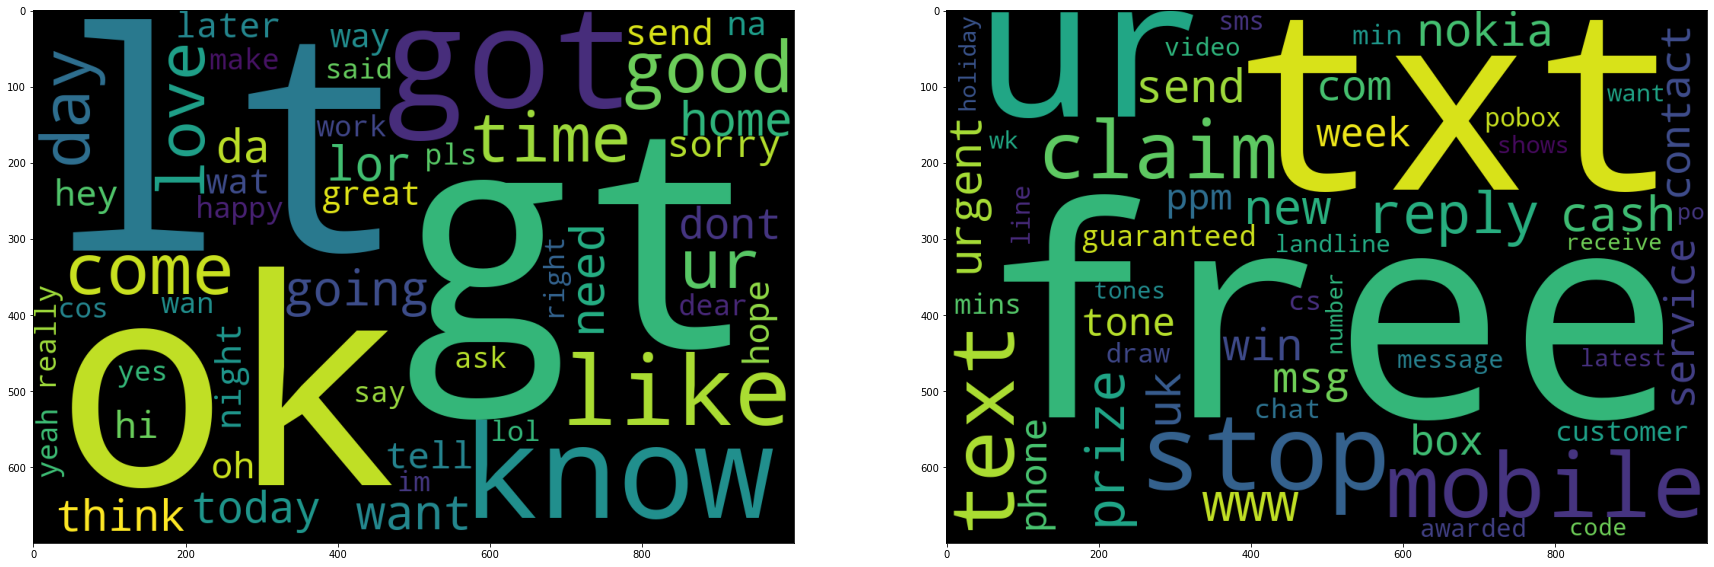

In [27]:
# cnt와 token만 묶어 넣어주고 plot!

plt.figure(figsize=(30,20))


plt.subplot(1,2,1)
count_dic = dict(zip(word_count_ham['words'], word_count_ham['counts']))
cloud = wc.generate_from_frequencies(count_dic)
plt.imshow(cloud)


plt.subplot(1,2,2)
count_dic = dict(zip(word_count_spam['words'], word_count_spam['counts']))
cloud = wc.generate_from_frequencies(count_dic)
plt.imshow(cloud)


오른쪽이 spam인데 token의 빈도수를 보면 free, cash, guranted, new, prize 등은 상업적인 단어로 광고등에서 많이 볼수 있는 단어입니다.    
또한 WWW, com과 같이 주소를 나타내는 단어도 있으며 customer와 같이 확실한 광고성 dataset임을 알 수 있습니다.    
반면 왼쪽은 Ham은 sorry, love, yes, need와 같은 평소에 친구간의 사용하는 단어가 많은것을 확인할 수 있습니다.  

In [28]:
spam_de = word_count_spam.sort_values('counts', ascending = False)
ham_de = word_count_ham.sort_values('counts', ascending = False)

In [29]:
dupli = set()
i = 1
while True:
    set_spam = set(spam_de.head(i).words.tolist())
    set_ham = set(ham_de.head(i).words.tolist())
    common = set_ham.intersection(set_spam)
    if len(common) == 20: break
    if dupli != common: print( f"{i} 번째로 중복되는 단어는 : ",common - dupli)
    i += 1
    dupli = common.copy()


9 번째로 중복되는 단어는 :  {'ur'}
25 번째로 중복되는 단어는 :  {'send'}
40 번째로 중복되는 단어는 :  {'want'}
55 번째로 중복되는 단어는 :  {'phone'}
57 번째로 중복되는 단어는 :  {'text'}
61 번째로 중복되는 단어는 :  {'day'}
62 번째로 중복되는 단어는 :  {'number'}
64 번째로 중복되는 단어는 :  {'week'}
66 번째로 중복되는 단어는 :  {'new'}
76 번째로 중복되는 단어는 :  {'free'}
84 번째로 중복되는 단어는 :  {'know'}
85 번째로 중복되는 단어는 :  {'today'}
89 번째로 중복되는 단어는 :  {'time'}
91 번째로 중복되는 단어는 :  {'yes', 'msg'}
96 번째로 중복되는 단어는 :  {'message'}
105 번째로 중복되는 단어는 :  {'dear'}
119 번째로 중복되는 단어는 :  {'thanks'}
121 번째로 중복되는 단어는 :  {'hi'}


#### spam과 ham을 빈도수별로 나열한 후 중복되는 것을 계산하면 위와 같은 결과가 나옵니다.  
확실히 내림차순으로 정렬했을때 앞부분에서는 spam과 ham이 서로 다른 단어가 많았던 반면 길이가 길어질수록 그 간격이 짧아집니다.  


## word to vector  
### skip-gram  

In [30]:
import gensim
gensim.__version__


## version마다 쫌 다른거 같아서 적어둡니다.

### (corpus, min_count=5, vector_size=100, window=2, epochs =80, sg=1) 으로 size와 iter가 바뀐거 같습니다.

'4.1.2'

In [31]:
path = '/home/mskang/hyeokjong/assignment/NLP/assi/'



model_spam = Word2Vec(spam[spam.v1 == 1]['v2'], min_count=0, vector_size=100, window=5, epochs=400,  sg=1)
model_spam.save(path + 'w2v_model_spam')
model_ham = Word2Vec(spam[spam.v1 == 0]['v2'],  min_count=0, vector_size=100, window=5, epochs=400,  sg=1)
model_ham.save(path + 'w2v_model_ham')

In [32]:
w2v_model_spam = Word2Vec.load(path + 'w2v_model_spam')
w2v_model_ham = Word2Vec.load(path + 'w2v_model_ham')

#### 두 모델을 가지고 가장 유사한 단어를 출력합니다.  
#### 앞에서 구한 공통적으로 빈도수가 높은것 위주로 비슷한 단어를 구해 보니다.  
#### 둘의 결과가 서로 다른지 비교해보면 spam과 ham에서 공통적으로 많이 사용된 단어일지리도 서로 다른 의미로 사용되었다는 것을 알수 있을겁니다.  

In [33]:
# 공통적으로 많이 사용된 단어 -> 앞에서와 같은 방법으로 해서 10개만 뽑습니다.
dupli = []
i = 1
while True:
    set_spam = set(spam_de.head(i).words.tolist())
    set_ham = set(ham_de.head(i).words.tolist())
    common = list(set_ham.intersection(set_spam))
    if len(common) == 10: break
    i += 1
    dupli = common.copy()
print(common)

['number', 'free', 'new', 'want', 'send', 'day', 'ur', 'phone', 'text', 'week']


#### 시각화를 어떻게 할지 몰라서 그냥 print하는데 그냥 naive하게 하면 너무 복잡해서 유사도 숫자는 제외하고 유사한 순서로 단어 10개씩 print

In [34]:
for i in common:
    new_ = []
    for j in w2v_model_spam.wv.most_similar(i,topn = 5 ):
        new_.append(j[0])
    print(i, "////",new_)
    print("-"*100)

number //// ['wot', 'oh', 'god', 'prepayment', 'found']
----------------------------------------------------------------------------------------------------
free //// ['panasonic', 'bluetoothhdset', 'doublemins', 'rayman', 'barkleys']
----------------------------------------------------------------------------------------------------
new //// ['comes', 'stuff', 'breaker', 'deluxe', 'ken']
----------------------------------------------------------------------------------------------------
want //// ['tonight', 'wamma', 'cock', 'laid', 'opinions']
----------------------------------------------------------------------------------------------------
send //// ['stopcs', 'tcr', 'frnd', 'cncl', 'meg']
----------------------------------------------------------------------------------------------------
day //// ['exit', 'blue', 'valentines', 'george', 'meetins']
----------------------------------------------------------------------------------------------------
ur //// ['balance', 'nok', 'sang'

In [35]:
for i in common:
    new_ = []
    for j in w2v_model_ham.wv.most_similar(i,topn = 5):
        new_.append(j[0])
    print(i, "////",new_)
    print("-"*100)

number //// ['vivek', 'anand', 'misplaced', 'clearer', 'yetty']
----------------------------------------------------------------------------------------------------
free //// ['messenger', 'katexxx', 'wikipedia', 'converter', 'video']
----------------------------------------------------------------------------------------------------
new //// ['infact', 'goal', 'zealand', 'melody', 'year']
----------------------------------------------------------------------------------------------------
want //// ['wizzle', 'worzels', 'mina', 'hypotheticalhuagauahahuagahyuhagga', 'denis']
----------------------------------------------------------------------------------------------------
send //// ['outs', 'yetty', 'computers', 'wrongly', 'comprehensive']
----------------------------------------------------------------------------------------------------
day //// ['tulsi', 'leaf', 'problms', 'litres', 'watr']
--------------------------------------------------------------------------------------------

free의 경우 spam에서는 제품명인 단어와 유사도가 높은반면 ham의 경우는 그렇지 안습니다.  
phone의 경우 spam에서는 latests, hottest, pay등과 같은 단어가 유사도가 높은것으로 보아 핸드폰 광고가 많음을 알 수 있습니다.


#### 두 결과를 보면 확실히 다름을 알 수 있습니다.  

### 추가로 차이가 있을거 같은 단어에 대해 진행합니다.

In [36]:
w2v_model_spam.wv.most_similar("nokia",topn = 10 )

[('latests', 0.6547600030899048),
 ('ou', 0.6499544382095337),
 ('panasonic', 0.6308599710464478),
 ('classic', 0.6085590124130249),
 ('bluetoothhdset', 0.6046634316444397),
 ('hv', 0.602048397064209),
 ('doublemins', 0.5930314064025879),
 ('deck', 0.5926947593688965),
 ('yhl', 0.5831376910209656),
 ('sppok', 0.5814232230186462)]

In [37]:
w2v_model_ham.wv.most_similar("nokia",topn = 10 )

[('lovly', 0.927181601524353),
 ('confirmd', 0.9268393516540527),
 ('motorola', 0.9239031076431274),
 ('verified', 0.8838074803352356),
 ('cnn', 0.8682413101196289),
 ('ibn', 0.8496193289756775),
 ('itz', 0.7587758898735046),
 ('surf', 0.6800537109375),
 ('cons', 0.6785113215446472),
 ('browser', 0.6766773462295532)]

특히 nokia라는 제품명을 비교해 볼때 spam과 ham의 차이가 분명함을 알 수 있습니다.

### CBOW

In [38]:
model_spam = Word2Vec(spam[spam.v1 == 1]['v2'],  min_count=0, vector_size=100, window=5, epochs=400, sg=0)
model_spam.save('w2v_model_spam')
model_ham = Word2Vec(spam[spam.v1 == 0]['v2'],  min_count=0, vector_size=100, window=5, epochs=400, sg=0)
model_ham.save('w2v_model_ham')

In [39]:
w2v_model_spam = Word2Vec.load('w2v_model_spam')
w2v_model_ham = Word2Vec.load('w2v_model_ham')

### 같은 방법을 반복합니다.  

In [40]:
for i in common:
    new_ = []
    for j in w2v_model_spam.wv.most_similar(i,topn = 5 ):
        new_.append(j[0])
    print(i, "////",new_)
    print("-"*100)

number //// ['bonus', 'arrive', 'million', 'camera', 'oh']
----------------------------------------------------------------------------------------------------
free //// ['get', 'colour', 'orange', 'plus', 'tariffs']
----------------------------------------------------------------------------------------------------
new //// ['shortly', 'services', 'explicit', 'anytime', 'dogging']
----------------------------------------------------------------------------------------------------
want //// ['laid', 'wamma', 'video', 'real', 'anytime']
----------------------------------------------------------------------------------------------------
send //// ['cancel', 'maximize', 'hlp', 'hmv', 'rcv']
----------------------------------------------------------------------------------------------------
day //// ['leave', 'exit', 'unique', 'leadership', 'lucy']
----------------------------------------------------------------------------------------------------
ur //// ['pounds', 'nok', 'txtin', 'mob', 

In [41]:
for i in common:
    new_ = []
    for j in w2v_model_ham.wv.most_similar(i,topn = 5 ):
        new_.append(j[0])
    print(i, "////",new_)
    print("-"*100)

number //// ['necessarily', 'text', 'zealand', 'bck', 'contact']
----------------------------------------------------------------------------------------------------
free //// ['connection', 'reach', 'wrk', 'frndship', 'lucyxx']
----------------------------------------------------------------------------------------------------
new //// ['experiment', 'splendid', 'bakrid', 'bognor', 'ishtamayoo']
----------------------------------------------------------------------------------------------------
want //// ['gt', 'lt', 'need', 'get', 'fiend']
----------------------------------------------------------------------------------------------------
send //// ['downloaded', 'back', 'bank', 'sender', 'gays']
----------------------------------------------------------------------------------------------------
day //// ['morning', 'boy', 'law', 'litres', 'problms']
----------------------------------------------------------------------------------------------------
ur //// ['u', 'comes', 'dict', 'di

In [67]:
w2v_model_spam.wv.most_similar("customer",topn = 10 )

[('code', 0.44982799887657166),
 ('freephone', 0.4110740125179291),
 ('please', 0.3897639513015747),
 ('line', 0.3889782726764679),
 ('loyalty', 0.3765520751476288),
 ('representative', 0.3739839196205139),
 ('reward', 0.36828577518463135),
 ('telephone', 0.34992626309394836),
 ('transferred', 0.34716445207595825),
 ('receivea', 0.3453623056411743)]

In [68]:
w2v_model_ham.wv.most_similar("customer",topn = 10 )

[('assistance', 0.6391382813453674),
 ('providing', 0.5901912450790405),
 ('jd', 0.5114373564720154),
 ('accounts', 0.5084315538406372),
 ('executive', 0.47774091362953186),
 ('initiate', 0.4713355302810669),
 ('delhi', 0.4597418010234833),
 ('voice', 0.4556322991847992),
 ('asa', 0.4332170784473419),
 ('phones', 0.43172600865364075)]

customer라는 단어가 spam 에서는 freephone loyalty reward telephone등과 같이 광고성 문장에 나올법한 단어들이 유사도가 높게 나왔습니다. 

### Fasttext

In [44]:
model_spam = FastText(spam[spam.v1 == 1]['v2'], vector_size=100, window=5, min_count=5, workers=4, sg=1)
model_ham = FastText(spam[spam.v1 == 0]['v2'], vector_size=100, window=5, min_count=5, workers=4, sg=1)

In [45]:
for i in common:
    new_ = []
    for j in model_spam.wv.most_similar(i,topn = 5 ):
        new_.append(j[0])
    print(i, "////",new_)
    print("-"*100)

number //// ['numbers', 'either', 'calling', 'contacted', 'guaranteed']
----------------------------------------------------------------------------------------------------
free //// ['phones', 'freemsg', 'phone', 'spree', 'reply']
----------------------------------------------------------------------------------------------------
new //// ['replying', 'news', 'reply', 'network', 'phones']
----------------------------------------------------------------------------------------------------
want //// ['important', 'video', 'tried', 'dont', 'unlimited']
----------------------------------------------------------------------------------------------------
send //// ['subscription', 'unsubscribe', 'custcare', 'charge', 'fancy']
----------------------------------------------------------------------------------------------------
day //// ['today', 'information', 'question', 'tenerife', 'lucky']
----------------------------------------------------------------------------------------------------


In [46]:
for i in common:
    new_ = []
    for j in model_ham.wv.most_similar(i,topn = 5 ):
        new_.append(j[0])
    print(i, "////",new_)
    print("-"*100)

number //// ['someone', 'sell', 'month', 'sometimes', 'months']
----------------------------------------------------------------------------------------------------
free //// ['bugis', 'rain', 'shows', 'cute', 'definitely']
----------------------------------------------------------------------------------------------------
new //// ['happen', 'happens', 'happiness', 'happened', 'may']
----------------------------------------------------------------------------------------------------
want //// ['wants', 'walk', 'waste', 'wanted', 'bored']
----------------------------------------------------------------------------------------------------
send //// ['pay', 'mind', 'sent', 'round', 'minutes']
----------------------------------------------------------------------------------------------------
day //// ['happening', 'new', 'hope', 'happen', 'hear']
----------------------------------------------------------------------------------------------------
ur //// ['abt', 'msg', 'aft', 'fren', 'den

In [65]:
model_spam.wv.most_similar("customer",topn = 10 )

[('summer', 0.9999095797538757),
 ('records', 0.9998964667320251),
 ('congratulations', 0.9998910427093506),
 ('currently', 0.9998896718025208),
 ('specially', 0.9998833537101746),
 ('unlimited', 0.9998822212219238),
 ('weekends', 0.9998818039894104),
 ('locations', 0.9998787641525269),
 ('either', 0.9998780488967896),
 ('offer', 0.9998776912689209)]

In [66]:
model_ham.wv.most_similar("customer",topn = 10 )

[('download', 0.9999331831932068),
 ('important', 0.9999322295188904),
 ('pictures', 0.9999294281005859),
 ('horrible', 0.9999290108680725),
 ('understand', 0.9999286532402039),
 ('complete', 0.9999285340309143),
 ('promise', 0.9999265670776367),
 ('seriously', 0.9999260306358337),
 ('planned', 0.9999248385429382),
 ('towards', 0.999923050403595)]

세 방법 모두 spam과 ham dataset의 결과가 꽤 다르게 나왔습니다.  
하지만 skip-gram과 cbow는 

In [ ]:
전반적으로 spam과 ham을 나누어 학습할때 완전 다른 결과가 나왔으며 세모델의 결과 모두 spam와 ham dataset의 특성에 맞게 결과가 나왔습니다. 

## 본인이 도출해낸 해석을 적어주세요! 위에 한번에 했습니다

- 유사도, Wordcloud, 이진 분류 모델, Plot 뭐든 상관없으니 분명하고 인상적인 해석을 적어주시면 됩니다.